### 【機械学習】

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', FutureWarning)

# シングルスイープのデータ
df = pd.read_csv("./data/01_single/output/ADS_out.csv", header=0)

# 不要なカラムを削除
df = df.drop(['Unnamed: 0.1'],axis=1)

# Refのリネーム
df = df.rename(columns={'Unnamed: 0':'Ref'})

df.head(1)

,Ref,Val,VTUNE12,fpeak,gain,fimg,img
0,C1,0.25,0.5,366000000,5.646318,266000000,123.9643


### デフォルトパラメータを入れる

In [2]:
# REFカラムの設定
ncolumn = ["C1","C2","C3","C4","C5","C6","C7",\
           "C8","C9","C10","C11","C12","C13",\
           "L1","L2","L3"]

# デフォルトパラメータ
# 各Refの行に新しい列へ値を入れる
for i, col in enumerate(ncolumn):
  if(i==0):
    df[col] = 12 # C1
  elif(i==1):
    df[col] = 27 # C2
  elif(i==2):
    df[col] = 8 # C3
  elif(i==3):
    df[col] = 2 # C4
  elif(i==4):
    df[col] = 22 # C5
  elif(i==5):
    df[col] = 6 # C6
  elif(i==6):
    df[col] = 4 # C7
  elif(i==7):
    df[col] = 18 # C8
  elif(i==8):
    df[col] = 1.5 # C9
  elif(i==9):
    df[col] = 1.5 # C10
  elif(i==10):
    df[col] = 18 # C11
  elif(i==11):
    df[col] = 2 # C12
  elif(i==12):
    df[col] = 1.5 # C13
  elif(i==13):
    df[col] = 27 # L1
  elif(i==14):
    df[col] = 27 # L2
  elif(i==15):
    df[col] = 11 # L3

df.head(1)

,Ref,Val,VTUNE12,fpeak,gain,fimg,img,C1,C2,C3,...,C7,C8,C9,C10,C11,C12,C13,L1,L2,L3
0,C1,0.25,0.5,366000000,5.646318,266000000,123.9643,12,27,8,...,4,18,1.5,1.5,18,2,1.5,27,27,11


In [3]:
# Refと一致する箇所に値を代入する
for col in ncolumn:
  df.loc[df.loc[:,"Ref"] == col,col] = df["Val"]

# 最後に不要なカラムを消す
df = df.drop("Ref", axis=1)
df = df.drop("Val", axis=1)

df.head(1)

,VTUNE12,fpeak,gain,fimg,img,C1,C2,C3,C4,C5,...,C7,C8,C9,C10,C11,C12,C13,L1,L2,L3
0,0.5,366000000,5.646318,266000000,123.9643,0.25,27.0,8.0,2.0,22.0,...,4.0,18.0,1.5,1.5,18.0,2.0,1.5,27.0,27.0,11.0


### 訓練データ、テストデータを作成

In [4]:
# 共通カラム + T12
ncolumn = ["C1","C2","C3","C4","C5","C6","C7",\
           "C8","C9","C10","C11","C12","C13",\
           "L1","L2","L3","VTUNE12"]

# [訓練データ]
# 「共通カラム(REF)」 + 「ターゲット列」のデータフレームを作る
train_df1 = pd.concat([df[ncolumn],df["fpeak"]],axis=1) # ピーク周波数
train_df2 = pd.concat([df[ncolumn],df["gain"]],axis=1) # ゲイン
train_df3 = pd.concat([df[ncolumn],df["img"]],axis=1) # イメージ

# [テストデータ]
# 訓練データからターゲット列を落とす
test_df1 = train_df1.drop("fpeak",axis=1)
test_df2 = train_df2.drop("gain",axis=1)
test_df3 = train_df3.drop("img",axis=1)

In [5]:
# LOGスケールに変換(ピーク周波数だけスケール大きいため)
train_df1["fpeak"] = np.log(train_df1["fpeak"])

In [6]:
# ライブラリ読み込み
import lightgbm as lgb
from sklearn.model_selection import KFold # K分割

# パラメータ設定
# (サロゲートモデルは過剰なチューニングしないこと)
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'mae',
    'boosting_type': 'gbdt', # BoostingのType
    'learning_rate': 0.01,   # 学習率　default = 0.1
    'random_state': 42,
    'verbose': -1            # ログ出力の制御
    }

# 訓練データから除外するカラム(ターゲット)
RMV1 = ["fpeak"]
RMV2 = ["gain"]
RMV3 = ["img"]

# 各データフレームの特徴量(ターゲットだけ外す)
FEATURES1 = [c for c in train_df1.columns if not c in RMV1]
FEATURES2 = [c for c in train_df2.columns if not c in RMV2]
FEATURES3 = [c for c in train_df3.columns if not c in RMV3]

In [7]:
%%time
##########################
###　　学習(シングル)　　###
##########################
def model_LGB(train, test, FEATURES, Target):

  FOLDS = 5 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  pred_lgb = np.zeros(len(test)) # バリデーション予測値
  models = [] # モデル
  evaluations_result = {} # 履歴

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # 訓練、検証データの格納
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, Target]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, Target]

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    # モデル保存
    models.append(model_lgb)

    # バリデーション予測
    pred_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  return models, pred_lgb, evaluations_result

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 6.91 μs


In [8]:
# 1.ピーク周波数
model1 = []
lgb_output1 = []
eval_result1 = {}
model1, lgb_output1, eval_result1 = model_LGB(train_df1, test_df1, FEATURES1, RMV1)

# 2.ゲイン
model2 = []
lgb_output2 = []
eval_result2 = {}
model2, lgb_output2, eval_result2 = model_LGB(train_df2, test_df2, FEATURES2, RMV2)

# 3.イメージ
model3 = []
lgb_output3 = []
eval_result3 = {}
model3, lgb_output3, eval_result3 = model_LGB(train_df3, test_df3, FEATURES3, RMV3)

#########################
### Fold 1
#########################
[100]	train's l1: 0.0375519	valid's l1: 0.0370603
[200]	train's l1: 0.0187666	valid's l1: 0.0184192
[300]	train's l1: 0.0111427	valid's l1: 0.0109939
[400]	train's l1: 0.00802023	valid's l1: 0.00801289
[500]	train's l1: 0.00679777	valid's l1: 0.00692288
[600]	train's l1: 0.00621856	valid's l1: 0.00641598
[700]	train's l1: 0.00591879	valid's l1: 0.00613383
[800]	train's l1: 0.00573397	valid's l1: 0.00598918
[900]	train's l1: 0.00560065	valid's l1: 0.00589257
[1000]	train's l1: 0.00549694	valid's l1: 0.00582855
[1100]	train's l1: 0.00540829	valid's l1: 0.0057665
[1200]	train's l1: 0.00531999	valid's l1: 0.00571338
[1300]	train's l1: 0.0052319	valid's l1: 0.00566953
[1400]	train's l1: 0.00513386	valid's l1: 0.00560657
[1500]	train's l1: 0.0050555	valid's l1: 0.00555721
[1600]	train's l1: 0.00499706	valid's l1: 0.0055084
[1700]	train's l1: 0.00494995	valid's l1: 0.00549444
[1800]	train's l1: 0.00489814	valid's l1: 0.00546675
[1

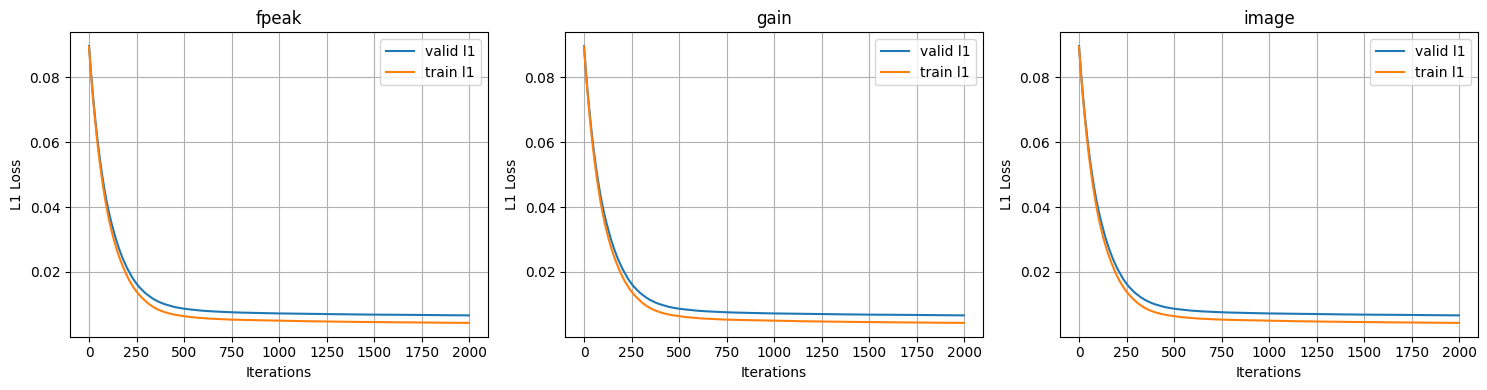

In [9]:
# 学習曲線の描画
plt.figure(figsize=(15, 4))

for i in range(3):

    plt.subplot(1,3,1+i)
    plt.plot(eval_result1['valid']['l1'], label='valid l1')
    plt.plot(eval_result1['train']['l1'], label='train l1')
    plt.xlabel('Iterations')
    plt.ylabel('L1 Loss')
    if(i==0):
        plt.title('fpeak')
    elif(i==1):
        plt.title('gain')
    else:
        plt.title('image')
    plt.legend()
    plt.grid()

# 隙間調整
plt.tight_layout()

# 描画
plt.show()

In [11]:
import shap

shap.initjs()

# 1000点サンプル
X_sample = [0]*3
X_sample[0] = train_df1.drop("fpeak", axis=1).sample(1000, random_state=42)
X_sample[1] = train_df2.drop("gain", axis=1).sample(1000, random_state=42)
X_sample[2] = train_df3.drop("img", axis=1).sample(1000, random_state=42)

# ===== SHAP平均を作る関数 =====
def get_shap_top5(shapval, X_sample, k=5):
    """SHAP値から上位k特徴を抽出して返す"""
    mean_abs = np.mean(np.abs(shapval), axis=0)
    top_idx = np.argsort(mean_abs)[-k:]
    return shapval[:, top_idx], X_sample.iloc[:, top_idx]

# ===== 各 fold の SHAP平均を作る =====
shapval = [0]*3
for j, val in enumerate(X_sample):
    for i in range(5):
        explainer = shap.TreeExplainer(model1[i])
        shapval[j] += explainer.shap_values(val)
    shapval[j] /= 5

In [13]:
# ===== 上位5特徴量抽出 =====
shap_top = [0] * 3 # SHAP上位
X_top = [0] * 3 # データサンプル

shap_top[0], X_top[0] = get_shap_top5(shapval[0], X_sample[0])
shap_top[1], X_top[1] = get_shap_top5(shapval[1], X_sample[1])
shap_top[2], X_top[2] = get_shap_top5(shapval[2], X_sample[2])

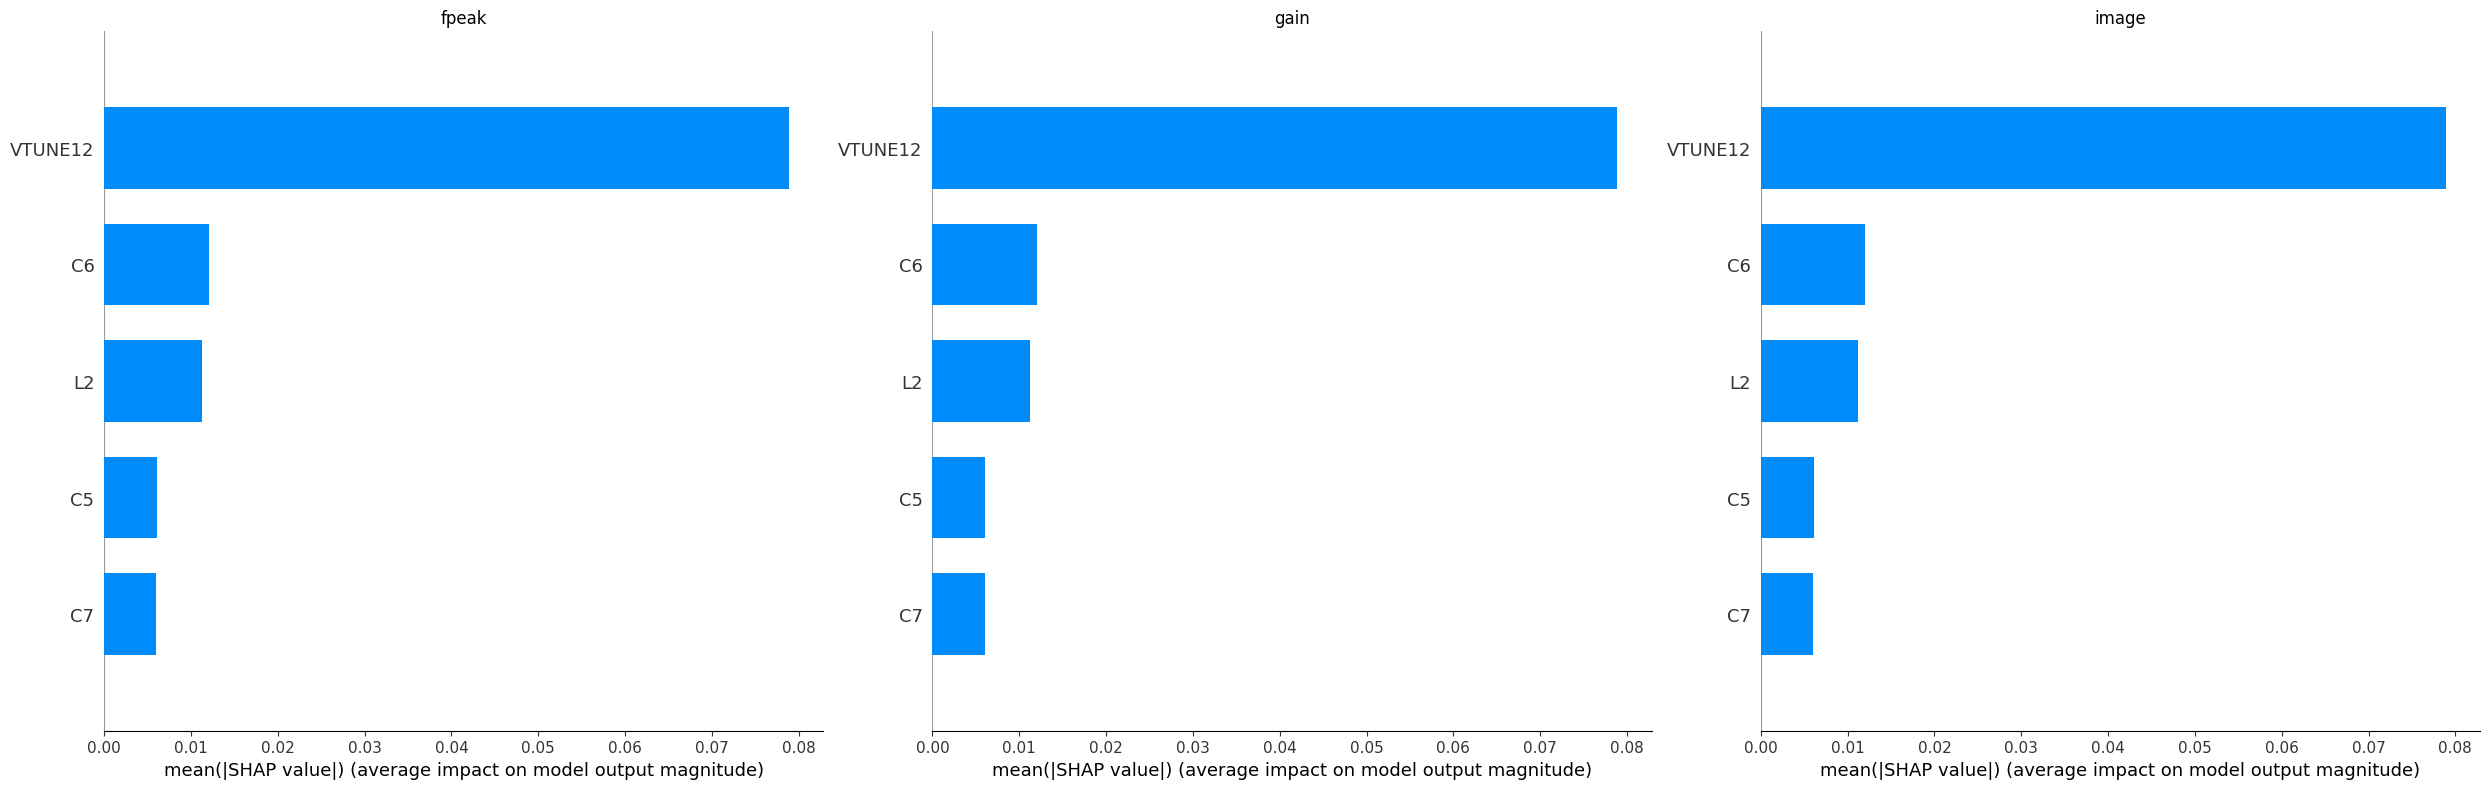

In [15]:
import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))

for i in range(3):

    ax1 = plt.subplot(1, 3, 1+i)
    shap.summary_plot(shap_top[i], X_top[i], plot_type="bar", show=False, plot_size=None)
    if(i==0):
        plt.title("fpeak")
    elif(i==1):
        plt.title("gain")
    else:
        plt.title("image")

# 隙間調整
plt.tight_layout()

# 描画
plt.show()